In [40]:
# Import libraries
import numpy as np
import MDAnalysis as mda
import nmrformd as nmrmd

recalculate=False

# For figure plotting
import sys
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
msize = 15
fontsize = 30
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}
myblue_light = [42/ 255, 99/255, 255/ 255] # [0/ 255, 150/255, 177/ 255]
myblue_dark = [43/ 255, 140/255, 238/ 255] # [0/ 255, 150/255, 177/ 255]
myred= [244/ 255, 143/255, 97/ 255] # [255/ 255, 77/255, 77/ 255]
mygreen = [122/255, 190/255, 165/255]
lightgray = [0.1, 0.1, 0.1]
darkgray = [0.9, 0.9, 0.9]
white = [0, 0, 0]
black = [1, 1, 1]
sys.path.append('../../shared/')
from tools import figure_improvement, save_figure

# Path to data
datapath = "../../raw-data/water-in-silica/N50/"

if recalculate:
    # Create a MDAnalysis universe
    u = mda.Universe(datapath+"prod.tpr", datapath+"prod.xtc")
    #u.transfer_to_memory(stop=50) # to analyse only a subpart of the trajectory

    # Print a few information
    timestep = np.int32(u.trajectory.dt)
    print(f"The timestep is {timestep} ps")
    total_time = np.int32(u.trajectory.totaltime)
    print(f"The total simulation time is {total_time} ps")

    # cut-off for frequency and time
    f_1 = 50
    t_1 = 100
    if u.trajectory.n_frames == 10001:
        f_1 = 1600
        t_1 = 8000

    group_H = u.select_atoms("type H*")
    group_H_water = u.select_atoms("resname SOL and type H*")
    group_H_silica = u.select_atoms("resname SiOH and type H*")

    n_water_molecules = group_H_water.n_residues
    print(f"The number of water molecules is {n_water_molecules}")

    TOTAL_nmr = nmrmd.NMR(u, group_H_water, neighbor_group=group_H, number_i=1, type_analysis='inter_molecular', isotropic=False)
    H2O_SILICA_nmr = nmrmd.NMR(u, group_H_water, neighbor_group=group_H_silica, number_i=1, isotropic=False)

    T1_TOTAL = np.round(TOTAL_nmr.T1,2)
    print(f"NMR relaxation time T1 - H2O - TOTAL = {T1_TOTAL} s")
    T1_H2O_SILICA = np.round(H2O_SILICA_nmr.T1,2)
    print(f"NMR relaxation time T1 - H2O - TOTAL = {T1_H2O_SILICA} s")

    f, R1_TOTAL = TOTAL_nmr.f[:-f_1], TOTAL_nmr.R1[:-f_1]
    np.savetxt("../../treated-data/tutorials/water-in-silica/R1_TOTAL.dat", np.vstack([f, R1_TOTAL]).T)
    f, R1_H2O_SILICA = H2O_SILICA_nmr.f[:-f_1], H2O_SILICA_nmr.R1[:-f_1]
    np.savetxt("../../treated-data/tutorials/water-in-silica/R1_H2O_SILICA.dat", np.vstack([f, R1_H2O_SILICA]).T)
    t, gij_TOTAL = TOTAL_nmr.t[:-t_1], TOTAL_nmr.gij.T[:-t_1].T
    np.savetxt("../../treated-data/tutorials/water-in-silica/gij_TOTAL.dat", np.vstack([TOTAL_nmr.t[:-t_1], TOTAL_nmr.gij.T[:-t_1].T]).T)
    t, gij_H2O_SILICA = H2O_SILICA_nmr.t[:-t_1], H2O_SILICA_nmr.gij.T[:-t_1].T
    np.savetxt("../../treated-data/tutorials/water-in-silica/gij_H2O_SILICA.dat", np.vstack([H2O_SILICA_nmr.t[:-t_1], H2O_SILICA_nmr.gij.T[:-t_1].T]).T)
else:
    f, R1_TOTAL = np.loadtxt("../../treated-data/tutorials/water-in-silica/R1_TOTAL.dat").T
    f, R1_H2O_SILICA = np.loadtxt("../../treated-data/tutorials/water-in-silica/R1_H2O_SILICA.dat").T
    data = np.loadtxt("../../treated-data/tutorials/water-in-silica/gij_TOTAL.dat").T
    t, gij_TOTAL = data[0], data[1:]
    data = np.loadtxt("../../treated-data/tutorials/water-in-silica/gij_H2O_SILICA.dat").T
    t, gij_H2O_SILICA = data[0], data[1:]

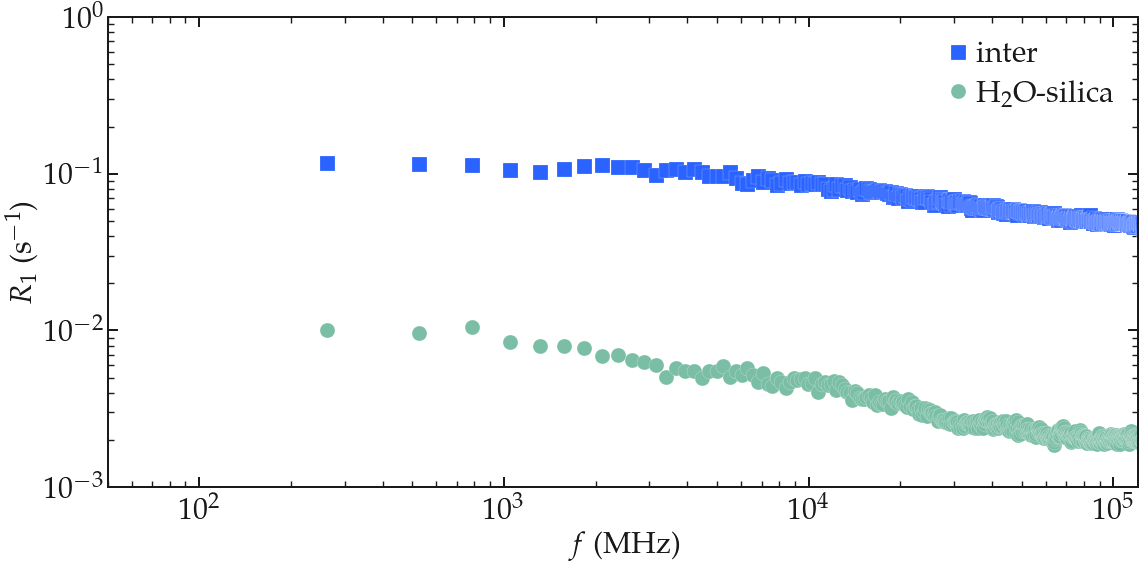

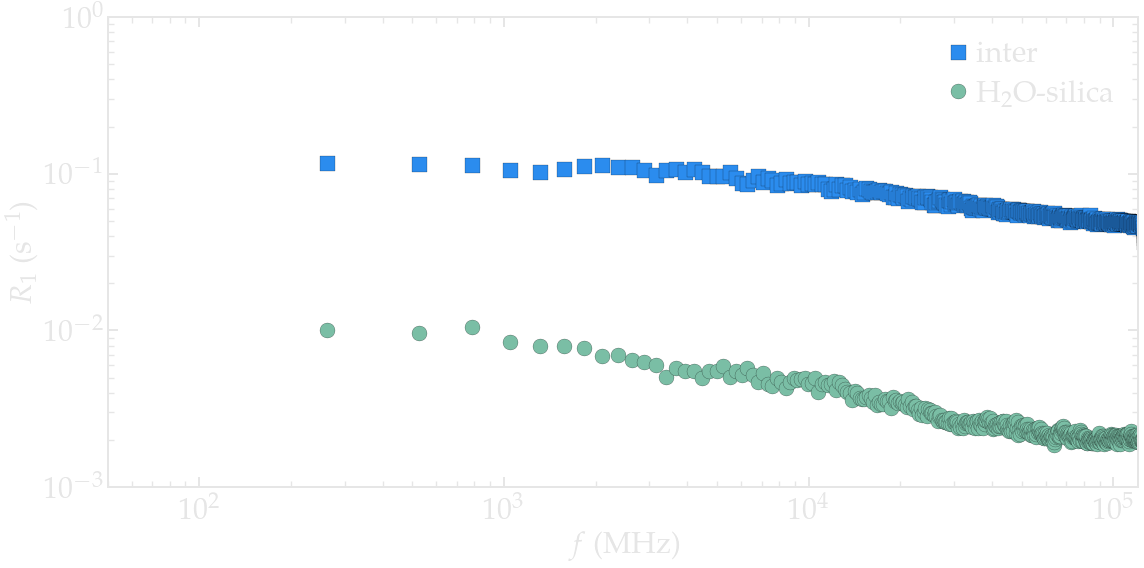

In [41]:
# R1 bulk
for mode, mygray, edge, myblue in zip(['light', 'dark'], [lightgray, darkgray], [black, white], [myblue_light, myblue_dark]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(f, R1_TOTAL, 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'inter')
    ax1.loglog(f, R1_H2O_SILICA, 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=mygreen, label=r'H$_2$O-silica')
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$R_1$ (s$^{-1}$)',
                       xlim=(5e1, 1.2e5), ylim=(0.001, 1))
    save_figure(plt, fig, mode, name='tutorials/water-in-silica/R1', save=True)

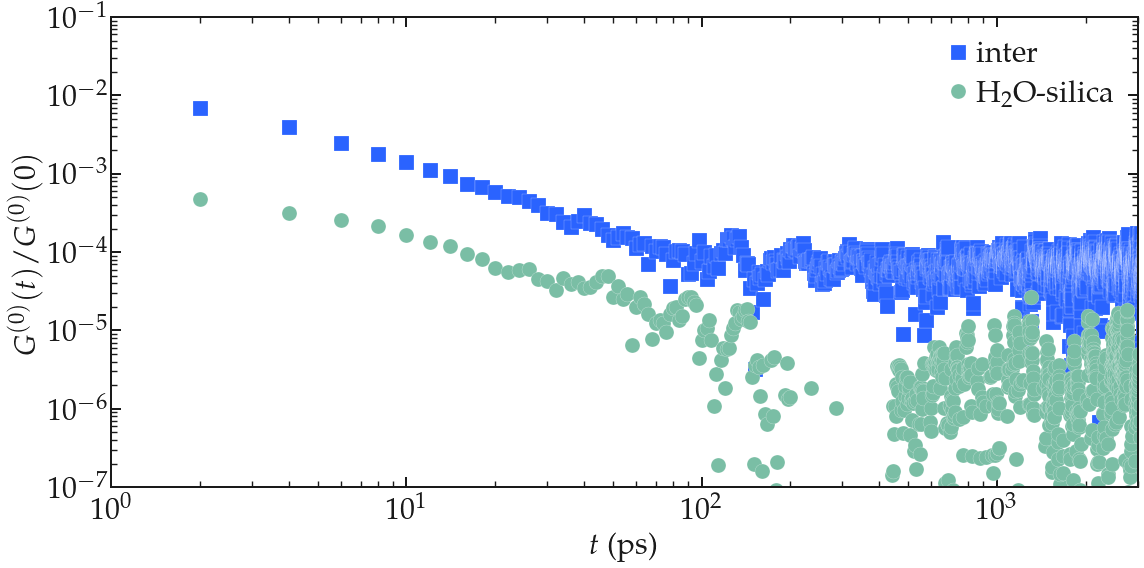

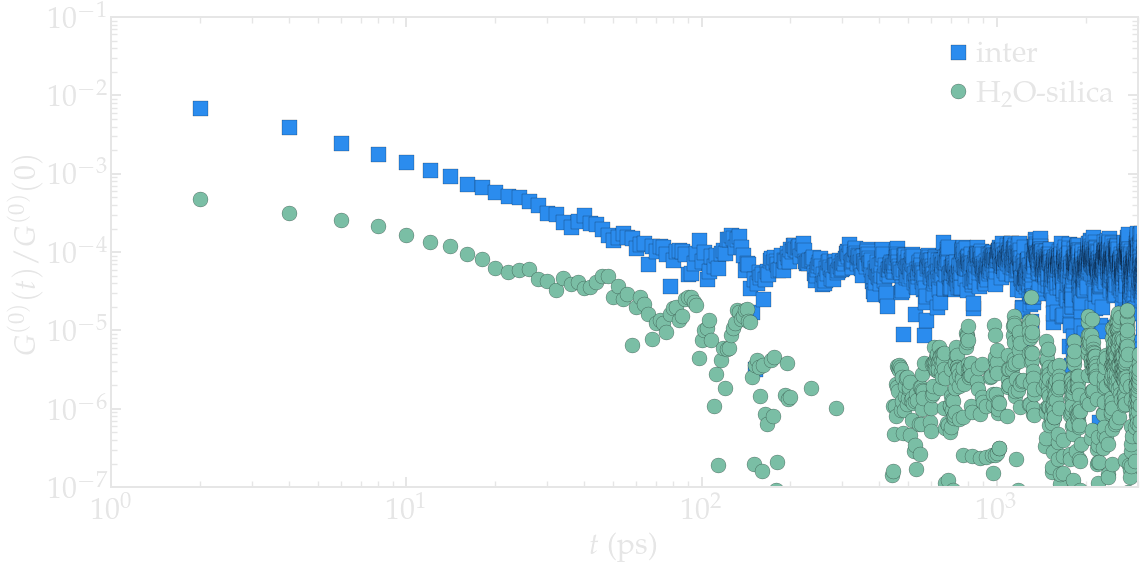

In [46]:
# Correlation function
for mode, mygray, edge, myblue in zip(['light', 'dark'], [lightgray, darkgray], [black, white], [myblue_light, myblue_dark]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(t, gij_TOTAL[0], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'inter')
    ax1.loglog(t, gij_H2O_SILICA[0], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=mygreen, label=r'H$_2$O-silica')
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(0)} (t) / G^{(0)} (0)$',
                       xlim=(1, 3e3), ylim=(1e-7, 0.1))
    save_figure(plt, fig, mode, name='tutorials/water-in-silica/Gij-0', save=True)

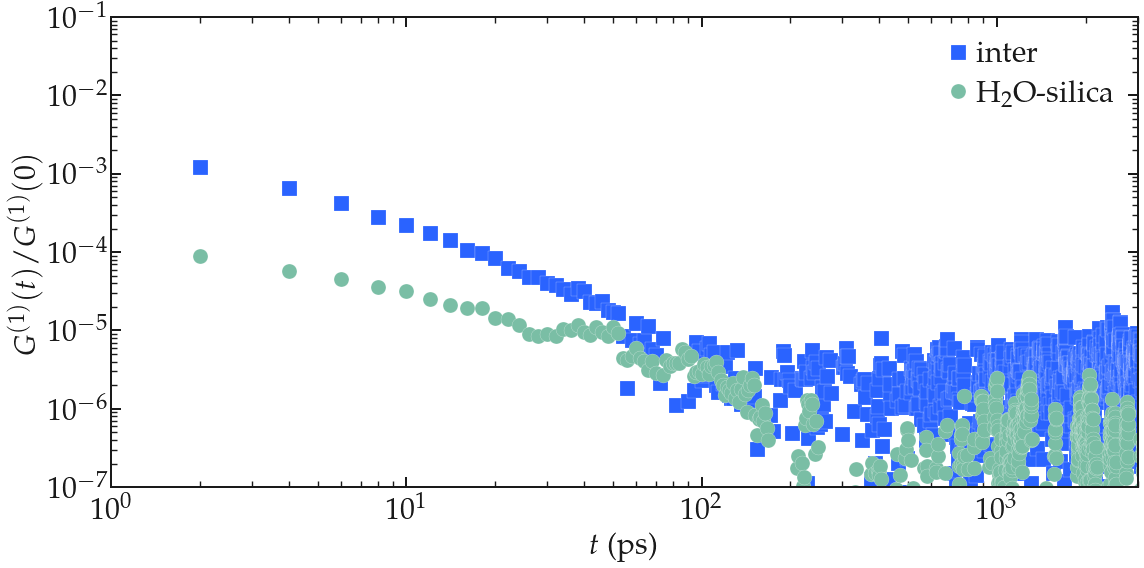

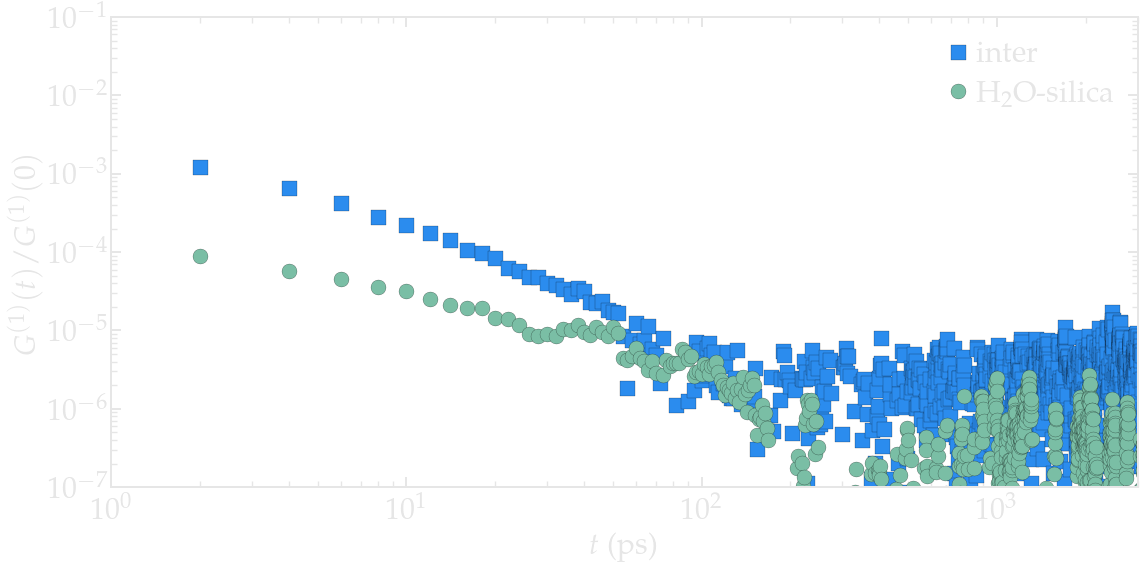

In [48]:
# Correlation function
for mode, mygray, edge, myblue in zip(['light', 'dark'], [lightgray, darkgray], [black, white], [myblue_light, myblue_dark]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(t, gij_TOTAL[1], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'inter')
    ax1.loglog(t, gij_H2O_SILICA[1], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=mygreen, label=r'H$_2$O-silica')
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(1)} (t) / G^{(1)} (0)$',
                       xlim=(1, 3e3), ylim=(1e-7, 0.1))
    save_figure(plt, fig, mode, name='tutorials/water-in-silica/Gij-1', save=True)

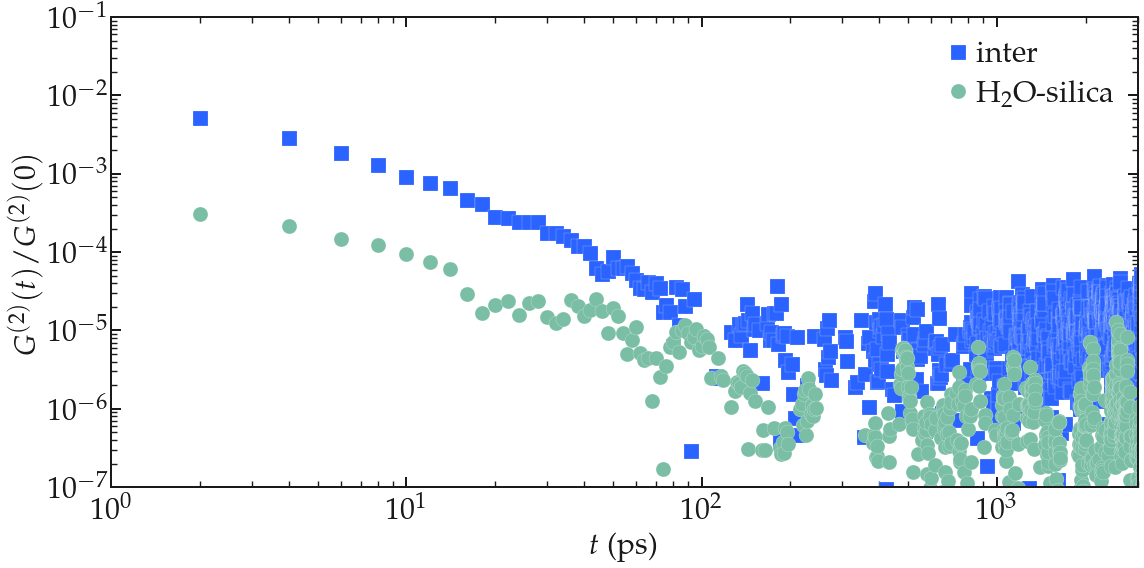

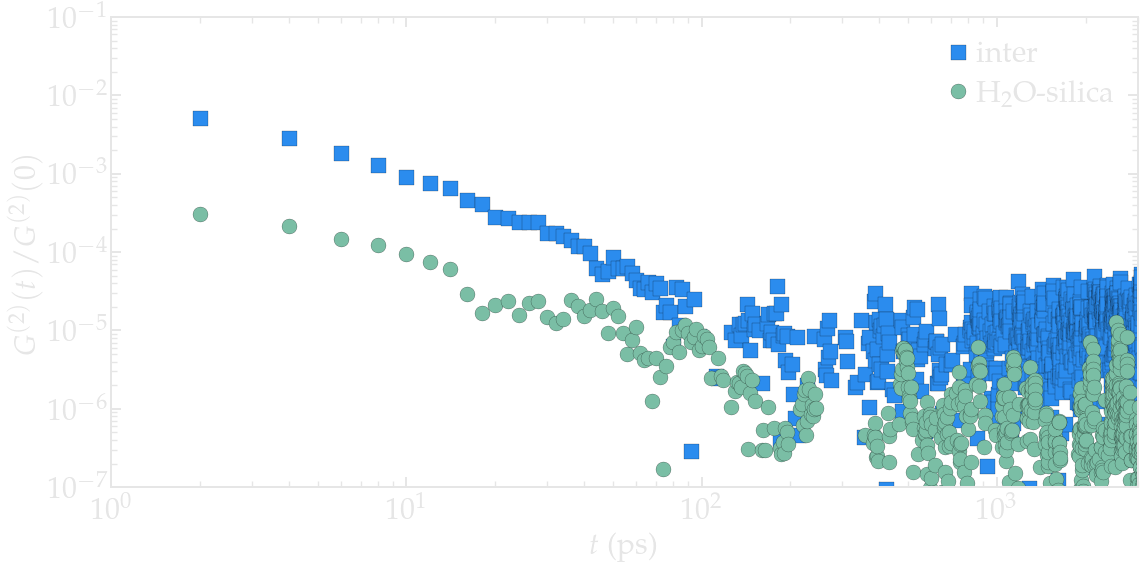

In [47]:
# Correlation function
for mode, mygray, edge, myblue in zip(['light', 'dark'], [lightgray, darkgray], [black, white], [myblue_light, myblue_dark]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(t, gij_TOTAL[2], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'inter')
    ax1.loglog(t, gij_H2O_SILICA[2], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=mygreen, label=r'H$_2$O-silica')
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(2)} (t) / G^{(2)} (0)$',
                       xlim=(1, 3e3), ylim=(1e-7, 0.1))
    save_figure(plt, fig, mode, name='tutorials/water-in-silica/Gij-2', save=True)